# libraries

In [2]:
from os import rename, times
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import re
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# print("asdf")

Matplotlib is building the font cache; this may take a moment.


# storing json file offline from codeforces

In [ ]:
# i have commented all the code because all useful data are extracted in list of 18 csv file ,
# run this code only when there is update in any logic because it takes time to extract all the data
# also from next time don't work on live api call just store the json format of all contest standing page and
# run it offline because sometimes it fails due to call more than 5 api in a second
contests = requests.get(
        "https://codeforces.com/api/contest.list")
json_file_1 = contests.json()
contests=json_file_1['result']
taken=1
cnt=1
saved=1
out=[]
for ids in contests:
  if(ids['phase']!='FINISHED'):
    continue
  id=str((ids['id']))
  standing= requests.get("https://codeforces.com/api/contest.standings?contestId="+id)
  print(id)
  json_file=standing.json()
  out.append(json_file)
  break
  


1523


In [ ]:
print(out[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




# api call using python and model creation for extracting data

In [ ]:
# i have commented all the code because all useful data are extracted in list of 18 csv file ,
# run this code only when there is update in any logic because it takes time to extract all the data
# also from next time don't work on live api call just store the json format of all contest standing page and
# run it offline because sometimes it fails due to call more than 5 api in a second
contests = requests.get(
        "https://codeforces.com/api/contest.list")

data = pd.DataFrame(columns=['contest_id','q_rating','contest_type', 'question_no','accuracy',
                             'avg_solving_time','sub_ratio','tried_but_cannot_solved','total_participant',
                             'total_correct_sub_for_each_q','total_sub_for_each_q','total_time_to_sove_q']) 
                              #sub_ratio=correct sub/total participnat
                              #accuracy=correct sub/total sub 
                              #avg sol time=sum of time of accepted sol/no of accepted sol
json_file_1 = contests.json()
contests=json_file_1['result']
taken=1
cnt=1
saved=1
for ids in contests:
  if(ids['phase']!='FINISHED'):
    continue
  id=str((ids['id']))
  # print(cnt,id)
  # id="1526"
  standing= requests.get("https://codeforces.com/api/contest.standings?contestId="+id)
  
  # print(standing.json()
  json_file=standing.json()
  if (json_file['status'])!="OK":
    time.sleep(2)
    continue
  re=json_file['result']['rows']
  contest_name=json_file['result']['contest']['name']
  print(cnt,contest_name)
  cnt+=1
  # useful data
  total_participant=len(re)
  total_correct_sub_for_each_question={}
  problem_rating={}
  tried_but_not_solved={}
  total_time_to_solve_q={}
  total_sub_for_each_question={}
  avg_solve_time_for_each_question={}
  total_no_of_question=0
  accuracy={}

  q_list=json_file['result']['problems']
  for i in q_list:
    # print(i['index'],i['rating'])
    if 'rating' in i:
      problem_rating[total_no_of_question+1]=i['rating']
    else:
      problem_rating[total_no_of_question+1]=-1
    total_no_of_question+=1
    total_time_to_solve_q[total_no_of_question]=0
    total_correct_sub_for_each_question[total_no_of_question]=0
    tried_but_not_solved[total_no_of_question]=0
    total_sub_for_each_question[total_no_of_question]=0
    accuracy[total_no_of_question]=0
  # print(problem_rating)
  # print(total_no_of_question)
  # print(re)
  for i in re:
    user_sub_for_each_q=i['problemResults']
    question_id=1
    temp=[]
    for i in user_sub_for_each_q:
      if('bestSubmissionTimeSeconds' in i):
        temp.append([i['bestSubmissionTimeSeconds'],question_id])
        total_correct_sub_for_each_question[question_id]+=1
      else:
        temp.append([0,question_id])
        if i['rejectedAttemptCount']>0:
          tried_but_not_solved[question_id]+=1
      question_id+=1
    temp.sort()
    prev_time=0
    for [x,y] in temp:
      total_time_to_solve_q[y]+=x-prev_time
      prev_time=x
    # print(total_time_to_solve_q)
  for i in range(total_no_of_question):
    total_sub_for_each_question[i+1]=total_correct_sub_for_each_question[i+1]+tried_but_not_solved[i+1]
    if total_sub_for_each_question[i+1]>0:
      accuracy[i+1]=total_correct_sub_for_each_question[i+1]/total_sub_for_each_question[i+1]

  #output
  # print(total_participant)
  # print(total_correct_sub_for_each_question)
  # print(total_sub_for_each_question)
  # print(tried_but_not_solved)
  # print(total_time_to_solve_q)
  # print("avg solving time in second")
  for i in range(total_no_of_question):
    if(total_correct_sub_for_each_question[i+1]>0):
      avg_solve_time_for_each_question[i+1]=total_time_to_solve_q[i+1]/total_correct_sub_for_each_question[i+1]
    else:
      avg_solve_time_for_each_question[i+1]=0
  # print(avg_solve_time_for_each_question)
  contest_type=4 #for all other contest
  if "Div. 3" in contest_name:
    contest_type=3
  if "Div. 2" in contest_name:
    contest_type=2
  if "Div. 1" in contest_name:
    contest_type=1 
  if "Global Round" in contest_name:
    contest_type=0
  for i in range(total_no_of_question):
    data=data.append({'contest_id':id,'q_rating':problem_rating[i+1],'contest_type':contest_type,'question_no':i+1,'accuracy':accuracy[i+1],
                      'avg_solving_time':avg_solve_time_for_each_question[i+1],'sub_ratio':total_correct_sub_for_each_question[i+1]/total_participant,
                      'tried_but_cannot_solved':tried_but_not_solved[i+1],'total_participant':total_participant,'total_correct_sub_for_each_q':
                      total_correct_sub_for_each_question[i+1],'total_sub_for_each_q':total_sub_for_each_question[i+1],'total_time_to_sove_q':
                      total_time_to_solve_q[i+1]},ignore_index=True)
  # print(data)
  # print(taken)
  if(taken%50==0):
    m=str(saved)
    data.to_csv('output'+m+'.csv',index=False)
    data = pd.DataFrame(columns=['contest_id','q_rating','contest_type', 'question_no','accuracy',
                             'avg_solving_time','sub_ratio','tried_but_cannot_solved','total_participant',
                             'total_correct_sub_for_each_q','total_sub_for_each_q','total_time_to_sove_q']) 
    saved+=1
    # break
  taken+=1
  # break
print(data)


# model with data 1

In [ ]:
# creating model
df=pd.read_csv('merged-1-to-18.csv')
#remove data of unrated round like technocup etc.....
# df=df.reset_index()
# print(df.head())
df=df[df.select_dtypes(include=[np.number]).ge(0).all(1)]# droping all row having any negative value in column
df=df.loc[(df['avg_solving_time']<=18000) & (df['avg_solving_time']>0)] #droping row having avg solving time is gratar than 10 hr and less than equal to 0
# df.head()
# df.describe()
# print(df.head())
print(df.describe())
q_1=df.loc[:,['question_no','q_rating','contest_type']]
q_1=q_1.loc[(q_1['question_no']==1) & (q_1['contest_type']==1)]
# print(q_1)
# print(q_1.describe())
x=df.drop(['q_rating'],axis=1)
# x=x.drop(['contest_id'],axis=1)
y=df['q_rating']
from sklearn.linear_model import LinearRegression
model=LinearRegression()
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.001,random_state=42)
model.fit(train_x,train_y)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
y_predict=model.predict(test_x)
# print(len(test_x))
y_predict
# test_y

FileNotFoundError: ignored

2561.8172573777692 2700
2677.3593217677044 3200
2269.317609391607 2800
1203.0693444258527 900
1368.2819495736492 2400
1692.3556780398076 1300


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


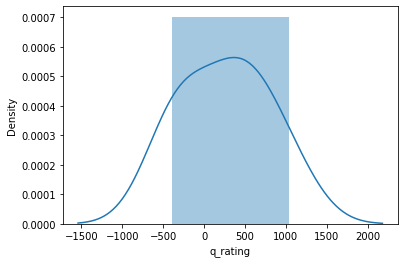

In [ ]:
# for i in range(len(y_predict)):
#   print(y_predict[i])
temp=[]
for i in test_y:
  temp.append(i)
for i in range(len(test_y)):
  print(y_predict[i],temp[i])
sns.distplot(test_y-y_predict)

In [ ]:
df.describe()

,contest_type,question_no,q_rating,accuracy,avg_solving_time
count,5223.000000,5223.000000,5223.000000,5223.000000,5223.000000
mean,2.270151,3.788244,1889.431361,0.630605,2468.171916
std,1.095918,2.254227,669.142115,0.260359,1354.840081
min,0.000000,1.000000,800.000000,0.002401,9.000000
25%,2.000000,2.000000,1400.000000,0.448239,1664.012265
50%,2.000000,4.000000,1900.000000,0.673913,2329.063830
75%,3.000000,5.000000,2400.000000,0.850912,3002.924197
max,4.000000,18.000000,3500.000000,1.000000,17935.148148


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8487824890>,
      dtype=object)

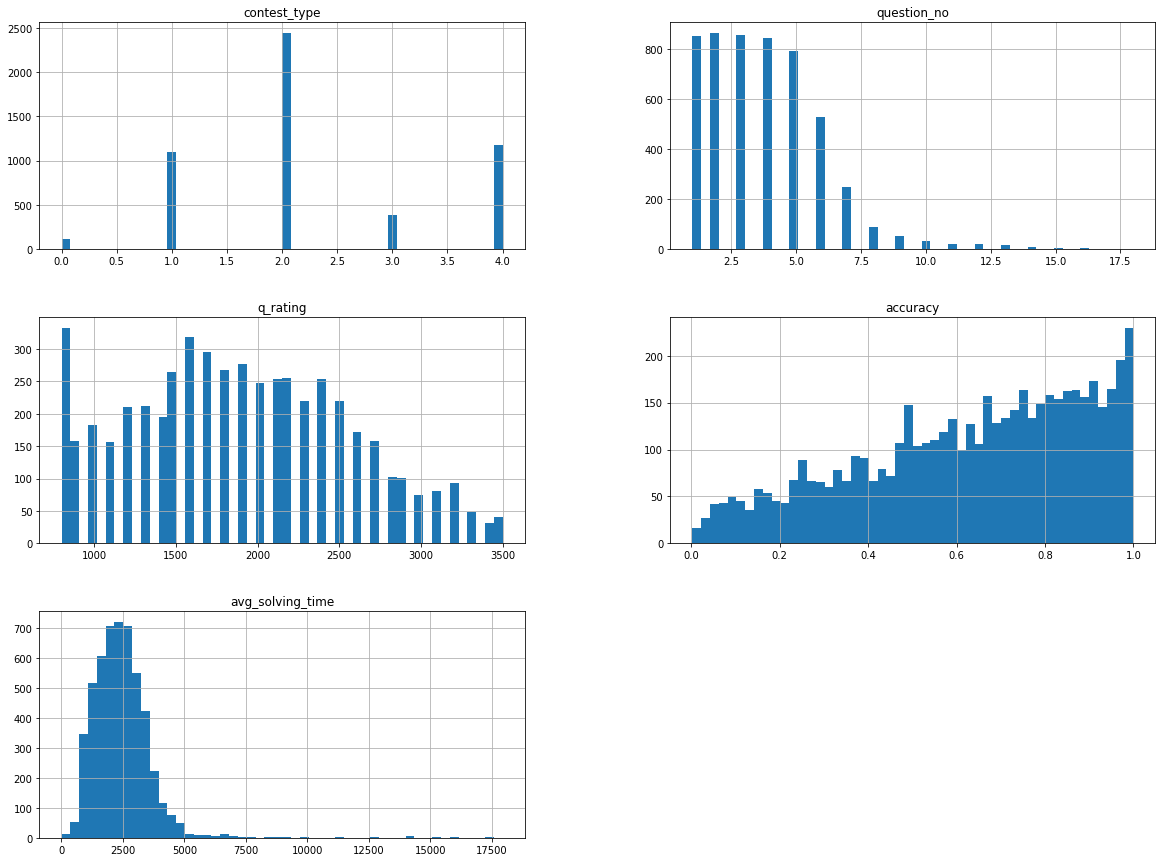

In [ ]:
df.hist(bins=50,figsize=(20,15))


**looking for correleatino**

In [ ]:
corr_matrix=df.corr()

In [ ]:
corr_matrix['q_rating'].sort_values(ascending=False)

q_rating            1.000000
question_no         0.627447
avg_solving_time    0.445529
contest_type       -0.126230
accuracy           -0.573784
Name: q_rating, dtype: float64

In [ ]:
from pandas.plotting import scatter_matrix  
attributes=["q_rating","accuracy"]
scatter_matrix(df[attributes],figsize=(28,18))

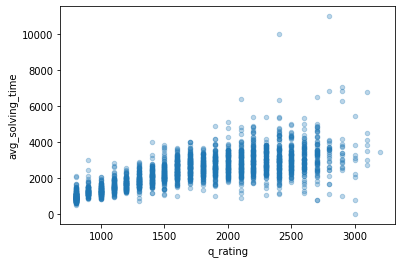

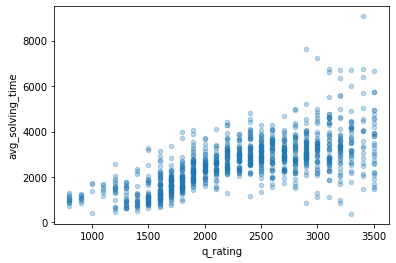

In [ ]:
df_div2=df.loc[(df['contest_type']==2)]
df_div1=df.loc[(df['contest_type']==1)]
# df_div2=df.loc[(df['contest_type']==2)]
# print(df.describe())
df_div2.plot(kind="scatter",x="q_rating",y="avg_solving_time",alpha=0.3)
df_div1.plot(kind="scatter",x="q_rating",y="avg_solving_time",alpha=0.3)

# model with data 2


In [24]:
# creating model
df=pd.read_csv('merged-1-to-16.csv')
#remove data of unrated round like technocup etc.....
# df=df.reset_index()
# print(df.head())
df=df[df.select_dtypes(include=[np.number]).ge(0).all(1)]# droping all row having any negative value in column
df=df.loc[(df['avg_solving_time']<=18000) & (df['avg_solving_time']>0)] #droping row having avg solving time is gratar than 10 hr and less than equal to 0
df_div0=df.loc[(df['contest_type']==0)]
df_div1=df.loc[(df['contest_type']==1)]
df_div2=df.loc[(df['contest_type']==2)]
df_div3=df.loc[(df['contest_type']==3)]
# print(df_div3.head())
# df.head()
# df.describe()
# print(df.head())
# print(df.describe())
q_1=df.loc[:,['question_no','q_rating','contest_type']]
q_1=q_1.loc[(q_1['question_no']==1) & (q_1['contest_type']==1)]
# print(q_1)
# print(q_1.describe())
x=df.drop(['q_rating'],axis=1)
x=x.drop(['contest_id'],axis=1)
y=df['q_rating']



    contest_id  q_rating  contest_type  question_no  accuracy  \
48        1520       800             3            1  0.968353   
49        1520       800             3            2  0.757368   
50        1520      1000             3            3  0.970073   
51        1520      1200             3            4  0.542378   
52        1520      1400             3            5  0.739506   

    avg_solving_time  sub_ratio  tried_but_cannot_solved  total_participant  \
48       1304.521798   0.865230                      530              18743   
49       1536.341482   0.641680                     3853              18743   
50       1609.363089   0.487702                      282              18743   
51       1285.970563   0.317185                     5016              18743   
52       1887.059512   0.155098                     1024              18743   

    total_correct_sub_for_each_q  total_sub_for_each_q  total_time_to_sove_q  
48                         16217                 16747 

# model training linear regression algo

In [ ]:
model=LinearRegression()
train_x_regresion,test_x_regresion,train_y_regresion,test_y_regresion=train_test_split(x,y,test_size=0.2,random_state=42)
model.fit(train_x_regresion,train_y_regresion)
# LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
y_predict_regresion=model.predict(test_x_regresion)
# print(len(test_x))
# y_predict

# output of linear regression algo

2138.5521620756413 1700 438.55216207564126
2427.5925732783476 2000 427.5925732783476
2141.145084975138 2100 41.14508497513816
2073.3734969573798 2000 73.37349695737976
2249.7757419972713 1800 449.7757419972713
1367.2625948242912 1400 32.73740517570877
1893.9612091233528 1700 193.96120912335277
2301.9413828114266 2000 301.9413828114266
605.1481128507289 1000 394.8518871492711
1381.9255917448945 1200 181.92559174489452
972.8233351261435 900 72.82333512614355
1530.6378188953136 1500 30.637818895313558
2297.6647084572946 2400 102.33529154270536
2595.4803356577054 3000 404.5196643422946
991.373773548039 900 91.37377354803903
1698.780809885087 1300 398.7808098850869
1473.7370183966673 1500 26.26298160333272
2198.6944535525336 1700 498.69445355253356
2106.701995944496 2000 106.70199594449605
2127.3630490772507 2000 127.36304907725071
2274.219086833498 2400 125.78091316650216
2505.753997873515 2600 94.24600212648511
1437.5605170427748 1800 362.4394829572252
2315.893876037958 2200 115.893876037

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


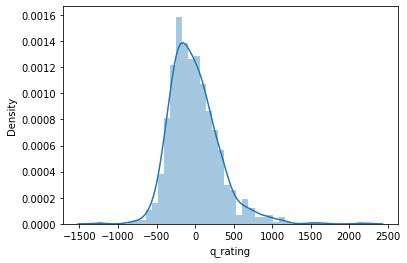

In [ ]:
# for i in range(len(y_predict)):
#   print(y_predict[i])
temp=[]
for i in test_y_regresion:
  temp.append(i)
rms_regression=0
for i in range(len(test_y_regresion)):
  rms_regression+=(y_predict_regresion[i]-temp[i])**2
  print(y_predict_regresion[i],temp[i],abs(y_predict_regresion[i]-temp[i]))
rms_regression/=len(test_y_regresion)
rms_regression=np.sqrt(rms_regression)
print("rmse error is=",rms_regression)
sns.distplot(test_y_regresion-y_predict_regresion)
# from sklearn.metrics import mean_squared_error
# rms_regression = mean_squared_error(train_y_regresion,y_predict_regresion , squared=False)


# model traning with random forest algo

In [10]:
model=RandomForestRegressor()
train_x_forest,test_x_forest,train_y_forest,test_y_forest=train_test_split(x,y,test_size=0.2,random_state=42)
model.fit(train_x_forest,train_y_forest)
y_predict_forest=model.predict(test_x_forest)
# y_predict

# model output of random forest

rmse error is= 150.97877475172433


C:\Users\amit kumar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='q_rating', ylabel='Density'>

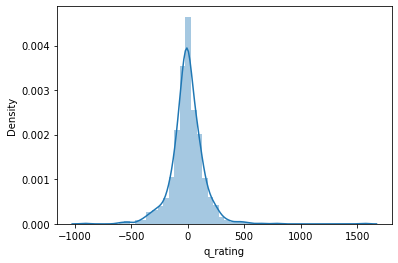

In [11]:
# for i in range(len(y_predict)):
#   print(y_predict[i])
temp=[]
for i in test_y_forest:
  temp.append(i)
rms_forest=0
for i in range(len(test_y_forest)):
  rms_forest+=(y_predict_forest[i]-temp[i])**2
rms_forest/=len(test_y_forest)
rms_forest=np.sqrt(rms_forest)
print("rmse error is=",rms_forest)
sns.distplot(test_y_forest-y_predict_forest)
# rms_forest = mean_squared_error(train_y_forest,y_predict_forest , squared=False)

# model training with DecisionTreeRegressor

In [ ]:
model=DecisionTreeRegressor()
train_x_tree,test_x_tree,train_y_tree,test_y_tree=train_test_split(x,y,test_size=0.2,random_state=42)
model.fit(train_x_tree,train_y_tree)
y_predict_tree=model.predict(test_x_tree)
# y_predict

# output of DecisionTreeRegressor

rmse error is= 195.017729690449


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


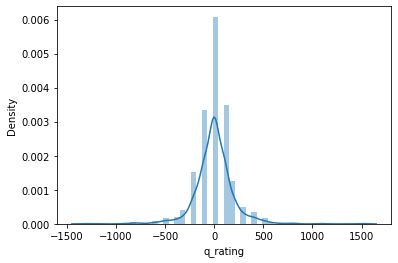

In [ ]:
temp=[]
for i in test_y_tree:
  temp.append(i)
rms_tree=0
for i in range(len(test_y_tree)):
  rms_tree+=(y_predict_tree[i]-temp[i])**2
rms_tree/=len(test_y_tree)
rms_tree=np.sqrt(rms_tree)
print("rmse error is=",rms_tree)
sns.distplot(test_y_tree-y_predict_tree)

# visualising data sets for div1 div2 combined

In [ ]:
df.head()

,contest_id,q_rating,contest_type,question_no,accuracy,avg_solving_time,sub_ratio,tried_but_cannot_solved,total_participant,total_correct_sub_for_each_q,total_sub_for_each_q,total_time_to_sove_q
3,1523,800,1,1,0.762553,1820.201740,0.731351,2076,9116,6667,8743,12135285
4,1523,1100,1,2,0.976143,1986.046843,0.592475,132,9116,5401,5533,10726639
5,1523,1600,1,3,0.767571,2162.557626,0.347411,959,9116,3167,4126,6848820
6,1523,2400,1,4,0.330375,2700.325373,0.036749,679,9116,335,1014,904609
7,1523,2600,1,5,0.962343,2279.865217,0.025230,9,9116,230,239,524369


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe256a8a90>,
      dtype=object)

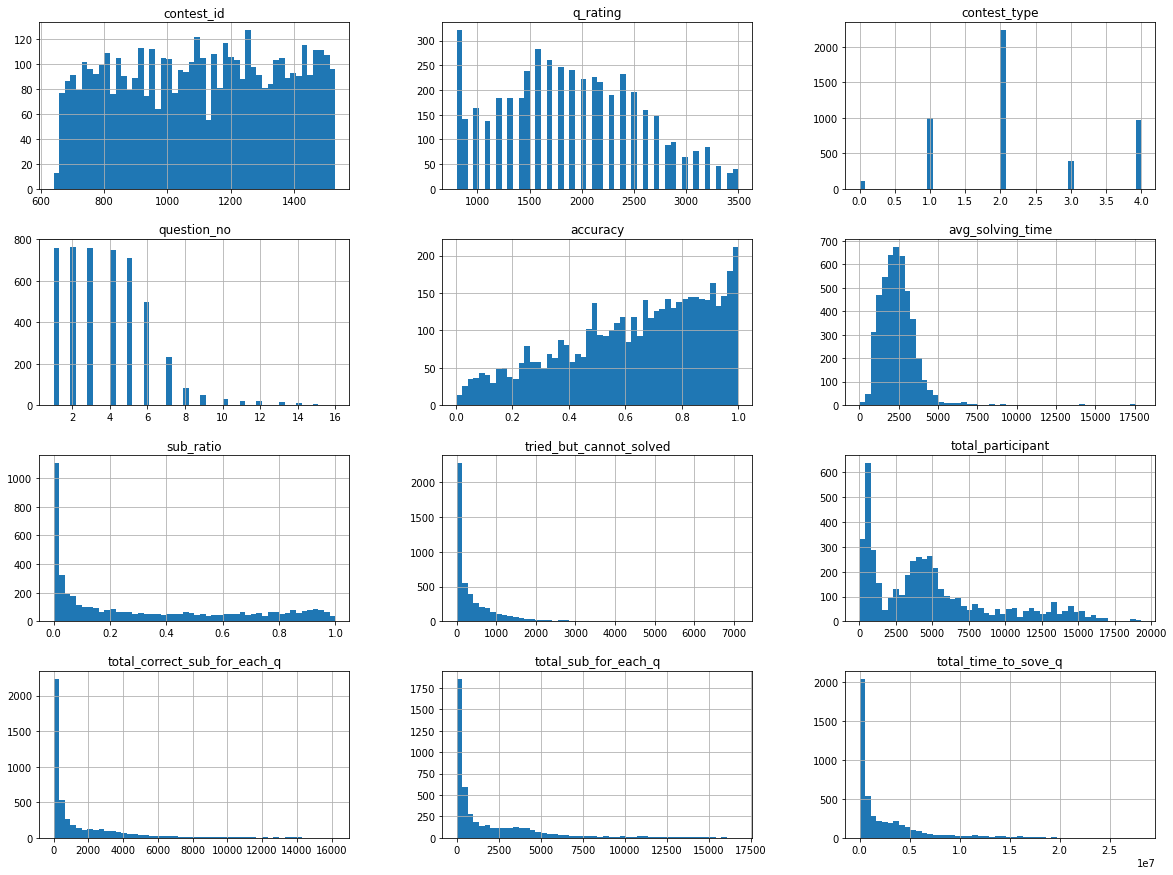

In [ ]:
df.hist(bins=50,figsize=(20,15))


In [ ]:
corr_matrix=df.corr()

In [ ]:
corr_matrix['q_rating'].sort_values(ascending=False)

q_rating                        1.000000
question_no                     0.641211
avg_solving_time                0.466707
contest_id                     -0.002909
contest_type                   -0.128358
total_participant              -0.235235
tried_but_cannot_solved        -0.401536
accuracy                       -0.574654
total_time_to_sove_q           -0.642421
total_correct_sub_for_each_q   -0.670790
total_sub_for_each_q           -0.677450
sub_ratio                      -0.784004
Name: q_rating, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe23b69350>,
      dtype=object)

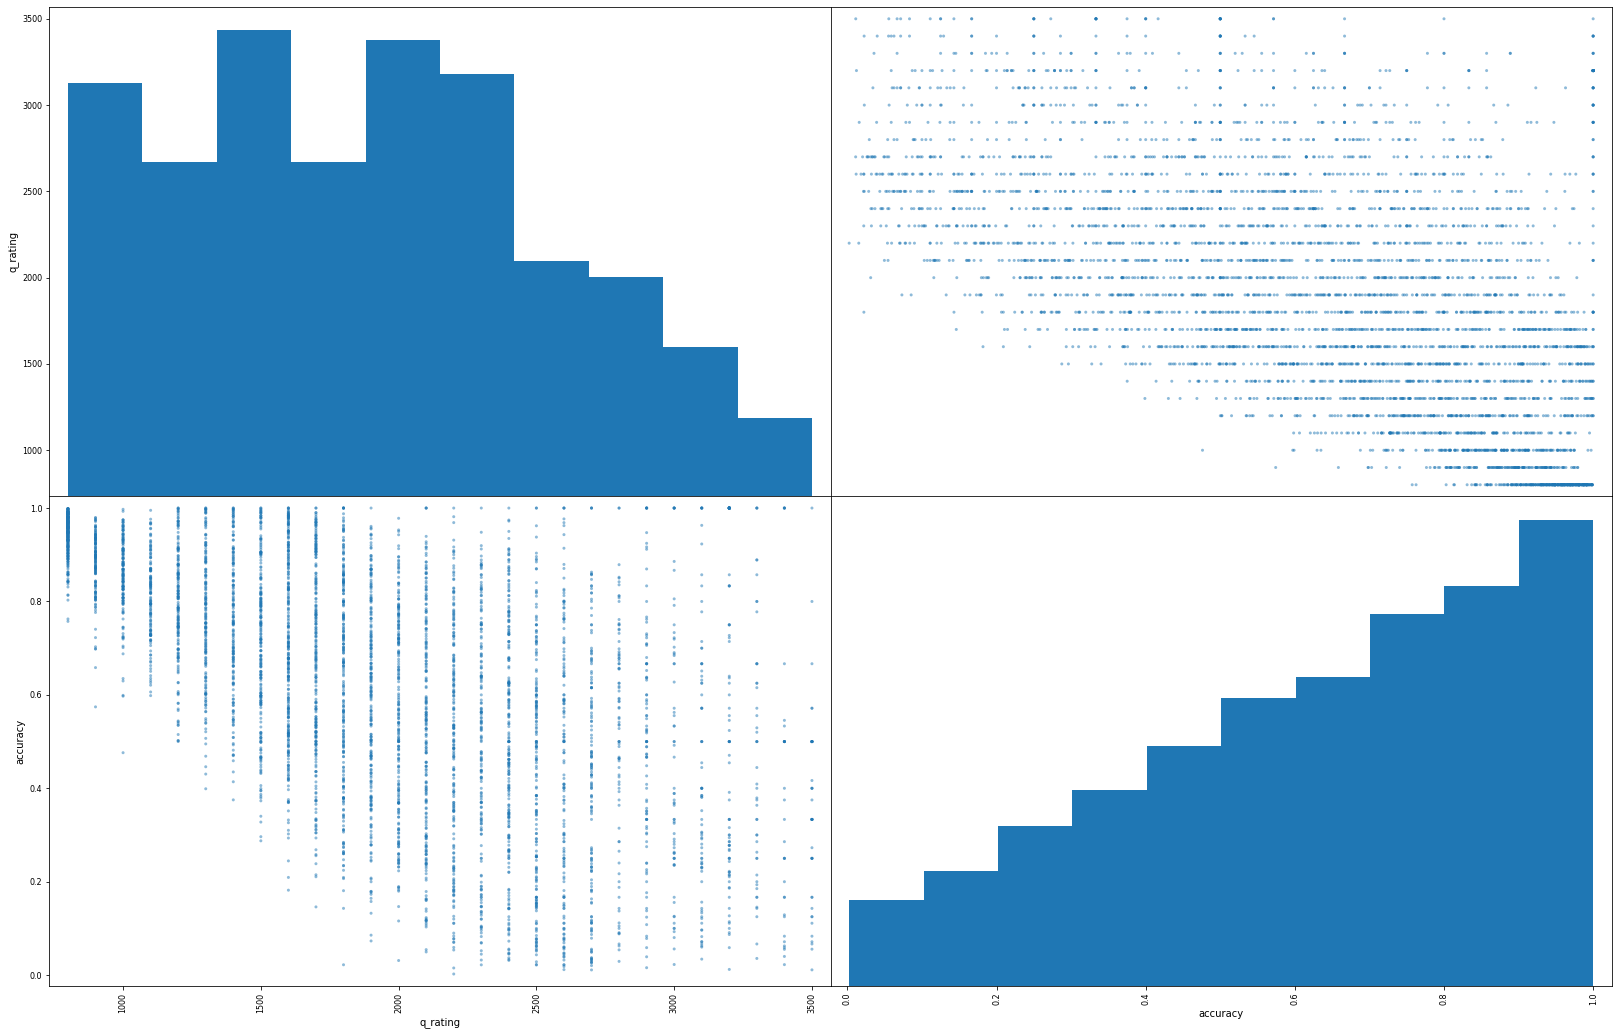

In [ ]:
from pandas.plotting import scatter_matrix  
attributes=["q_rating","accuracy"]
scatter_matrix(df[attributes],figsize=(28,18))

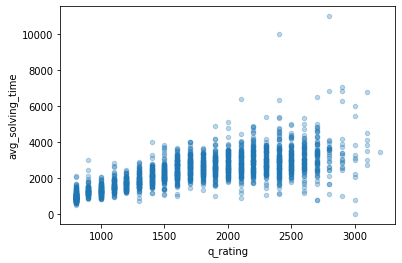

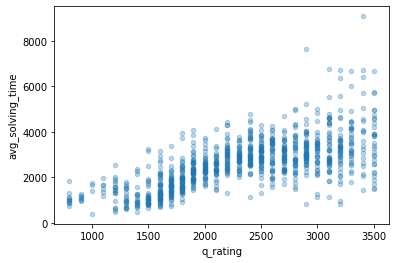

In [ ]:
df_div2_comb=df.loc[(df['contest_type']==2)]
df_div1_comb=df.loc[(df['contest_type']==1)]
# df_div2=df.loc[(df['contest_type']==2)]
# print(df.describe())
df_div2_comb.plot(kind="scatter",x="q_rating",y="avg_solving_time",alpha=0.3)
df_div1_comb.plot(kind="scatter",x="q_rating",y="avg_solving_time",alpha=0.3)

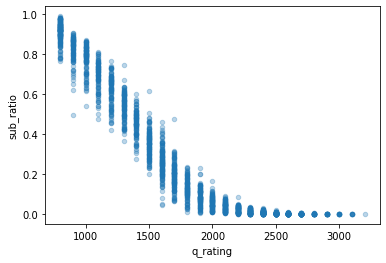

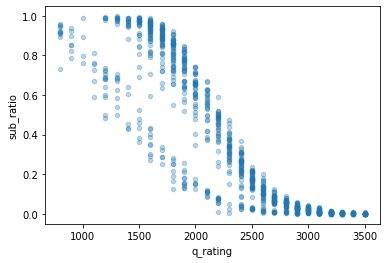

In [ ]:
df_div2_comb=df.loc[(df['contest_type']==2)]
df_div1_comb=df.loc[(df['contest_type']==1)]
# df_div2=df.loc[(df['contest_type']==2)]
# print(df.describe())
df_div2_comb.plot(kind="scatter",x="q_rating",y="sub_ratio",alpha=0.3)
df_div1_comb.plot(kind="scatter",x="q_rating",y="sub_ratio",alpha=0.3)

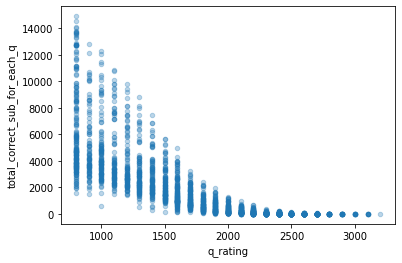

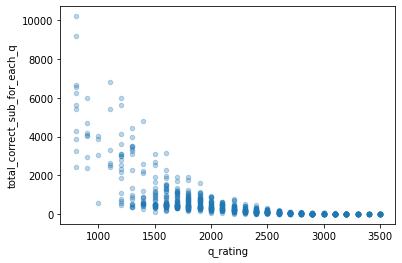

In [ ]:
df_div2_comb=df.loc[(df['contest_type']==2)]
df_div1_comb=df.loc[(df['contest_type']==1)]
# df_div2=df.loc[(df['contest_type']==2)]
# print(df.describe())
df_div2_comb.plot(kind="scatter",x="q_rating",y="total_correct_sub_for_each_q",alpha=0.3)
df_div1_comb.plot(kind="scatter",x="q_rating",y="total_correct_sub_for_each_q",alpha=0.3)

# visualising data sets div1 div2 seperatly

In [5]:
df_div1=df_div1.drop(['contest_id','total_participant','total_time_to_sove_q'],axis=1)
df_div2=df_div2.drop(['contest_id','total_participant','total_time_to_sove_q'],axis=1)
df_div3=df_div3.drop(['contest_id','total_participant','total_time_to_sove_q'],axis=1)

NameError: name 'df_div1' is not defined

In [ ]:
df_div1.describe()

,q_rating,contest_type,question_no,accuracy,avg_solving_time,sub_ratio,tried_but_cannot_solved,total_correct_sub_for_each_q,total_sub_for_each_q
count,995.000000,995.0,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,2324.723618,1.0,3.475377,0.661430,2601.541381,0.362734,142.467337,479.269347,621.736683
std,659.317829,0.0,1.899949,0.247346,1085.822004,0.356926,316.824145,997.491059,1204.719178
min,800.000000,1.0,1.000000,0.015291,389.748682,0.000099,0.000000,1.000000,1.000000
25%,1800.000000,1.0,2.000000,0.500000,1819.659441,0.028635,12.000000,21.000000,44.000000
50%,2300.000000,1.0,3.000000,0.705882,2611.954955,0.214592,41.000000,155.000000,266.000000
75%,2900.000000,1.0,5.000000,0.869627,3256.990660,0.719904,111.500000,471.000000,546.000000
max,3500.000000,1.0,13.000000,1.000000,9074.000000,0.997396,2976.000000,10209.000000,10789.000000


In [ ]:
df_div1.head()

,q_rating,contest_type,question_no,accuracy,avg_solving_time,sub_ratio,tried_but_cannot_solved,total_correct_sub_for_each_q,total_sub_for_each_q
3,800,1,1,0.762553,1820.201740,0.731351,2076,6667,8743
4,1100,1,2,0.976143,1986.046843,0.592475,132,5401,5533
5,1600,1,3,0.767571,2162.557626,0.347411,959,3167,4126
6,2400,1,4,0.330375,2700.325373,0.036749,679,335,1014
7,2600,1,5,0.962343,2279.865217,0.025230,9,230,239


In [ ]:
df_div2.describe()

,q_rating,contest_type,question_no,accuracy,avg_solving_time,sub_ratio,tried_but_cannot_solved,total_correct_sub_for_each_q,total_sub_for_each_q
count,2234.000000,2234.0,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,1716.830797,2.0,3.497762,0.598942,2350.411271,0.319589,650.538944,2071.115936,2721.654879
std,595.560213,0.0,1.811108,0.264248,959.854820,0.327073,808.129650,2680.814973,3092.210012
min,800.000000,2.0,1.000000,0.002401,9.000000,0.000070,1.000000,1.000000,2.000000
25%,1200.000000,2.0,2.000000,0.400000,1647.464140,0.017665,98.250000,94.000000,252.250000
50%,1700.000000,2.0,3.000000,0.637580,2332.714035,0.196077,370.000000,1005.000000,1819.500000
75%,2200.000000,2.0,5.000000,0.826213,2944.849630,0.604092,876.000000,3133.000000,3997.000000
max,3200.000000,2.0,13.000000,0.998742,11008.000000,0.988967,7112.000000,14896.000000,15854.000000


In [ ]:
df_div3.describe()

,q_rating,contest_type,question_no,accuracy,avg_solving_time,sub_ratio,tried_but_cannot_solved,total_correct_sub_for_each_q,total_sub_for_each_q
count,387.000000,387.0,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,1479.328165,3.0,3.935401,0.655428,1885.553600,0.344281,687.317829,3188.196382,3875.514212
std,475.445320,0.0,2.013803,0.246634,574.398676,0.330747,751.454803,3829.067704,4113.017983
min,800.000000,3.0,1.000000,0.021583,620.779187,0.000184,2.000000,2.000000,5.000000
25%,1100.000000,3.0,2.000000,0.477287,1438.675990,0.025024,151.500000,238.500000,531.000000
50%,1500.000000,3.0,4.000000,0.690000,1904.832967,0.231663,470.000000,1731.000000,2709.000000
75%,1900.000000,3.0,6.000000,0.860659,2284.224137,0.642125,915.500000,4654.500000,5501.000000
max,2700.000000,3.0,9.000000,0.999073,3739.000000,0.980294,5016.000000,16217.000000,16747.000000


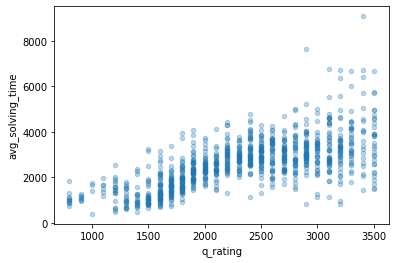

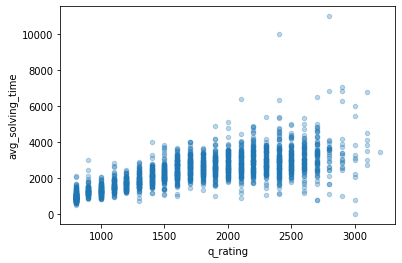

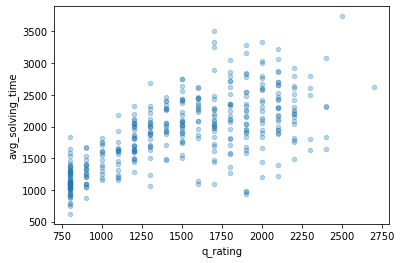

In [ ]:
df_div1.plot(kind="scatter",x="q_rating",y="avg_solving_time",alpha=0.3)
df_div2.plot(kind="scatter",x="q_rating",y="avg_solving_time",alpha=0.3)
df_div3.plot(kind="scatter",x="q_rating",y="avg_solving_time",alpha=0.3)

In [ ]:
df_div1.plot(kind="scatter",x="q_rating",y="sub_ratio",alpha=0.3)
df_div2.plot(kind="scatter",x="q_rating",y="sub_ratio",alpha=0.3)
df_div3.plot(kind="scatter",x="q_rating",y="sub_ratio",alpha=0.3)

# model with seperate div 1 and div 2 div3 data

**Div 1**

In [21]:
x_div1=df_div1.drop(['q_rating'],axis=1)
# x_div1=x_div1.drop(['contest_id'],axis=1)
y_div1=df_div1['q_rating']
# print(x_div1.head())
# print(y_div1.head())
model=RandomForestRegressor()
train_x_forest_div1,test_x_forest_div1,train_y_forest_div1,test_y_forest_div1=train_test_split(x_div1,y_div1,test_size=0.2,random_state=42)
model.fit(train_x_forest_div1,train_y_forest_div1)
y_predict_forest_div1=model.predict(test_x_forest_div1)
# test_x_forest_div11=[[1,5,0.056	,4440,0.00709219858,22,1,23]]
# y_predict_forest_div11=model.predict(test_x_forest_div11)
# print(y_predict_forest_div11)
# y_predict

ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 8 

# output div 1


1632.0 1600
2443.0 2500
1613.0 1500
2883.0 2900
1746.0 1700
1531.0 1700
1331.0 1200
1628.0 1400
3010.0 3100
1739.0 1600
1505.0 1700
2673.0 2800
2727.0 2800
3170.0 3000
3022.0 3100
2205.0 2300
2323.0 2400
3252.0 3300
1615.0 1700
2287.0 2400
1808.0 1700
2713.0 2700
2204.0 2200
2922.0 3000
2890.0 2800
2291.0 2400
2739.0 2800
2895.0 2900
1949.0 2100
2285.0 2300
2654.0 2600
2813.0 2700
3147.0 3100
1654.0 1700
1798.0 2000
1955.0 1800
2035.0 2100
1533.0 1600
1467.0 1500
2870.0 3000
2820.0 2800
3304.0 3500
1547.0 1600
2360.0 2300
1755.0 1800
2981.0 3000
2998.0 3100
3179.0 3200
2503.0 2500
3379.0 3500
2500.0 2400
3153.0 3300
2856.0 3100
3090.0 3000
2978.0 2900
1545.0 1700
3278.0 3300
2300.0 2300
3416.0 3500
1572.0 1800
1646.0 1600
2363.0 2400
1937.0 2000
1775.0 1800
2304.0 2300
3356.0 3300
1885.0 1900
2332.0 2400
2247.0 2400
2372.0 2400
3121.0 3100
2192.0 2200
2912.0 3000
3394.0 3500
3122.0 3100
3210.0 3200
1521.0 1400
1696.0 1700
1599.0 1600
1924.0 1900
3265.0 3300
1309.0 1300
2320.0 2300
3442

C:\Users\amit kumar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='q_rating', ylabel='Density'>

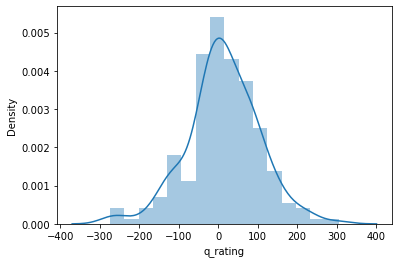

In [20]:
temp=[]
for i in test_y_forest_div1:
  temp.append(i)
rms_forest_div1=0
for i in range(len(test_y_forest_div1)):
  rms_forest_div1+=(y_predict_forest_div1[i]-temp[i])**2
  print(y_predict_forest_div1[i],temp[i])
rms_forest_div1/=len(test_y_forest_div1)
rms_forest_div1=np.sqrt(rms_forest_div1)
print("rmse error is=",rms_forest_div1)
sns.distplot(test_y_forest_div1-y_predict_forest_div1)

# Output div 2

In [14]:
x_div2=df_div2.drop(['q_rating'],axis=1)
# x_div2=x_div2.drop(['contest_id'],axis=1)
y_div2=df_div2['q_rating']
model=RandomForestRegressor()
train_x_forest_div2,test_x_forest_div2,train_y_forest_div2,test_y_forest_div2=train_test_split(x_div2,y_div2,test_size=0.05,random_state=42)
print(train_x_forest_div2.describe())
model.fit(train_x_forest_div2,train_y_forest_div2)
y_predict_forest_div2=model.predict(test_x_forest_div2)
# y_predict

        contest_id  contest_type  question_no     accuracy  avg_solving_time  \
count  2122.000000        2122.0  2122.000000  2122.000000       2122.000000   
mean   1117.919887           2.0     3.505184     0.598739       2357.391969   
std     251.279371           0.0     1.809457     0.264139        965.429574   
min     664.000000           2.0     1.000000     0.002401          9.000000   
25%     909.000000           2.0     2.000000     0.400207       1652.326005   
50%    1132.000000           2.0     3.000000     0.636364       2334.911765   
75%    1338.500000           2.0     5.000000     0.825171       2952.125000   
max    1529.000000           2.0    13.000000     0.998742      11008.000000   

         sub_ratio  tried_but_cannot_solved  total_participant  \
count  2122.000000              2122.000000        2122.000000   
mean      0.318106               642.697926        6586.535344   
std       0.326551               795.825949        3753.310480   
min       0.000

2245.0 2300
1085.0 1100
1026.0 1100
1355.0 1400
1029.0 1300
2699.0 2500
1699.0 1600
2717.0 2800
1913.0 1700
1551.0 1500
2164.0 2200
2437.0 2400
1541.0 1500
1512.0 1500
2636.0 2700
1126.0 1100
930.0 900
1497.0 1400
1003.0 1000
970.0 800
1876.0 1900
2205.0 2000
2163.0 2100
808.0 1000
2677.0 2600
2394.0 2400
800.0 800
896.0 1000
2107.0 1900
2079.0 2200
2435.0 2700
1115.0 1200
1439.0 1500
1553.0 1600
965.0 1000
934.0 1000
2036.0 2000
800.0 800
1303.0 1300
1576.0 1600
857.0 800
800.0 800
1170.0 1100
802.0 800
1091.0 1100
1588.0 1600
1779.0 1600
1717.0 1700
2582.0 2500
2603.0 2300
1684.0 1700
2078.0 2200
2220.0 2400
949.0 900
2546.0 2600
1000.0 1100
831.0 800
2045.0 2100
2097.0 2100
2051.0 2000
2279.0 1900
1629.0 1700
1235.0 1300
1029.0 1000
2331.0 2400
1114.0 1100
2591.0 2900
1049.0 1000
2162.0 2100
1160.0 1100
1595.0 1500
2837.0 2500
1917.0 1900
2694.0 2500
915.0 1000
1791.0 1800
1717.0 1800
1088.0 1000
2534.0 2700
1432.0 1300
1131.0 1200
1634.0 1600
1786.0 1800
902.0 900
2535.0 2600
827.0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


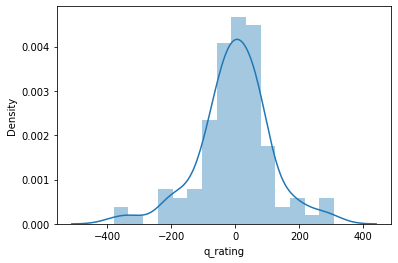

In [ ]:
temp=[]
for i in test_y_forest_div2:
  temp.append(i)
rms_forest_div2=0
for i in range(len(test_y_forest_div2)):
  rms_forest_div2+=(y_predict_forest_div2[i]-temp[i])**2
  print(y_predict_forest_div2[i],temp[i])
rms_forest_div2/=len(test_y_forest_div2)
rms_forest_div2=np.sqrt(rms_forest_div2)
print("rmse error is=",rms_forest_div2)
sns.distplot(test_y_forest_div2-y_predict_forest_div2)

# output div3

In [15]:
x_div3=df_div3.drop(['q_rating'],axis=1)
# x_div2=x_div2.drop(['contest_id'],axis=1)
y_div3=df_div3['q_rating']
model=RandomForestRegressor()
train_x_forest_div3,test_x_forest_div3,train_y_forest_div3,test_y_forest_div3=train_test_split(x_div3,y_div3,test_size=0.2,random_state=42)
model.fit(train_x_forest_div3,train_y_forest_div3)
y_predict_forest_div3=model.predict(test_x_forest_div3)
# y_predict

2104.0 2200
1754.0 1800
946.0 900
1694.0 1700
2133.0 2100
836.0 800
1455.0 1500
1979.0 2100
1206.0 1200
1623.0 1600
1803.0 1800
1210.0 1200
1353.0 1400
2073.0 2100
2105.0 2200
1214.0 1200
2050.0 2100
1466.0 1500
1228.0 1300
1231.0 1200
800.0 800
936.0 1000
1858.0 2000
892.0 800
1197.0 1200
845.0 800
1793.0 1800
883.0 800
1642.0 1700
812.0 800
1414.0 1400
822.0 800
1273.0 1200
966.0 900
1269.0 1300
1750.0 1700
835.0 800
829.0 800
1709.0 1800
1216.0 1200
1241.0 1200
1462.0 1400
1517.0 1500
1202.0 1200
2203.0 2200
1486.0 1600
800.0 800
2017.0 2100
813.0 800
1405.0 1400
1590.0 1600
1931.0 2000
1564.0 1600
1653.0 1700
882.0 900
2029.0 2100
891.0 900
800.0 800
2509.0 2200
946.0 1000
800.0 800
1201.0 1200
1670.0 1700
1005.0 1000
1638.0 1600
927.0 900
1660.0 1700
1297.0 1300
2392.0 2500
800.0 800
1218.0 1200
962.0 1000
1222.0 1200
1424.0 1400
1128.0 1100
1501.0 1500
1649.0 1600
800.0 800
rmse error is= 60.47917632731756


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


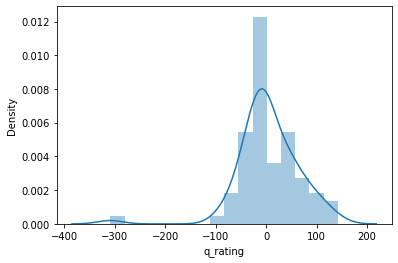

In [ ]:
temp=[]
for i in test_y_forest_div3 :
  temp.append(i)
rms_forest_div3=0
for i in range(len(test_y_forest_div3)):
  rms_forest_div3+=(y_predict_forest_div3[i]-temp[i])**2
  print(y_predict_forest_div3[i],temp[i])
rms_forest_div3/=len(test_y_forest_div3)
rms_forest_div3=np.sqrt(rms_forest_div3)
print("rmse error is=",rms_forest_div3)
sns.distplot(test_y_forest_div3-y_predict_forest_div3)